## Discord Discovery: HOT SAX

### Paul Anzel DATEDATEDATE

[HOT SAX!](http://www.cs.ucr.edu/~eamonn/discords/HOT%20SAX%20%20long-ver.pdf)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import pandas as pd
import time
import marisa_trie

%matplotlib inline

from numba import jit

sns.set_style('white')

/Users/anzelp/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


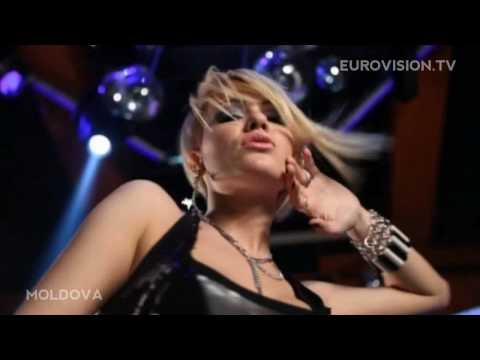

In [2]:
from IPython.display import YouTubeVideo
YouTubeVideo('ECyeUYsU14E')

This is actually a technique for finding __discords__, which are segments of a repeating time series which are weird (or, more specifically, unlike all the other ones). To take two examples (from the paper above), you might be looking at a heartbeat, and you want to see if any beats miss (as evidence of a medical problem). Or you're watching someone's breathing patterns as they go from sleeping to being awake.

In [3]:
M = 500
t_array = np.linspace(0, 30, M)
dt = t_array[1]-t_array[0]
one_period = 4/dt
print(round(one_period))

np.random.seed(135)
x_array = np.sin(np.pi*t_array/2) + 0.1*np.random.randn(M)
x_array[200:240] = x_array[200:240] - 0.7 + .3*np.random.randn(40)

67.0


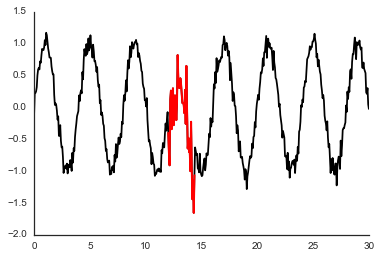

In [4]:
plt.plot(t_array, x_array, color='k')
plt.plot(t_array[200:240], x_array[200:240], color='r', linewidth=2)

sns.despine()

The basic idea goes as follows--imagine you've got some time series data of length $M$, and your data has some basic period $N \ll M$ (perhaps one heart beat out of a dozen, or 10 breaths over several minutes). You can take two contiguous subsequences $x$ and $y$ of length $N$ from your data (making sure the subsequences don't overlap, or in the terminology of the paper, are __non-self-matching__) and find some distance $D(x, y)$. The discord is the subsequence $d$ that has the largest distance to any other non-self-matching subsequence.

The naive idea for doing this goes as follows--iterate over all possible pairs of subsequences, and take the RMS difference between the subsequences:

$$D(x, y) = \sqrt{\sum_i (x_i - y_i)^2}$$

An inefficent algorithm goes as follows:

In [5]:
def RMS_distance(x, y):
    # x and y are N length np arrays.
    return np.sqrt(np.sum(np.power(x - y, 2)))

In [6]:
@jit
def get_discord_naive(X, N):
    M = len(X)
    assert N < M, "N must be smaller than the length of X"
    highest_distance = 0
    number_of_calls_to_RMS = 0
    p_candidate = np.nan
    for p in range(M-N):
        x_p = X[p:(p+N)]
        lowest_distance_p = np.inf
        for q in range(M-N):
            if np.abs(p-q) < N:
                # preventing self-matches
                continue
            x_q = X[q:(q+N)]
            dist = RMS_distance(x_p, x_q)
            number_of_calls_to_RMS += 1
            lowest_distance_p = min(lowest_distance_p, dist)
        if lowest_distance_p > highest_distance:
            p_candidate = p
            highest_distance = lowest_distance_p
    return p_candidate, highest_distance, number_of_calls_to_RMS

In [7]:
%timeit get_discord_naive(x_array, 67)

1 loop, best of 3: 1.51 s per loop


In [8]:
p, rms_dist, num_calls = get_discord_naive(x_array, 67)

Number of calls: 134322
Starting point of discord: 200


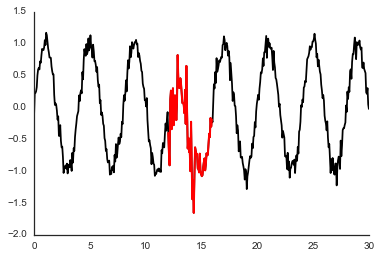

In [9]:
print('Number of calls: %d' % num_calls)
print('Starting point of discord: %d' % p)

plt.plot(t_array, x_array, color='k')
plt.plot(t_array[p:(p+66)], x_array[p:(p+66)], color='r', linewidth=2)

sns.despine()

N.B.: We were extremely lucky to get the discord starting right at the point I set (index 200), given that the flaw I made was only 40 units long. With a different random seed, you'll get something close to 200 but definitely containing the 40-unit subseuquence.

Because we are iterating from 0 to $M-N$ twice, this algorithm has $O(M^2)$ complexity. We could be a bit smarter: cache some of the distance calculations, and only really compute RMS distance for $q > p$, and cut the number of RMS calls in half. But this will require a fair amount of memory and we still have the same complexity.

We have some ways to improve the algorithm above:
- If we calculate a ``dist`` below your current running ``highest_distance``, you can stop iterating on that specific $p$, since you know that candidate will not be the discord.
- If you had some idea of how discordant a dataset is, you'd run that one first to try and establish a high value of ``highest_distance`` right off the bat. Then, for all the other potential $p$'s, you'd try and pick a $q$ so that the compared signal is pretty close, trying to set your first ``dist`` as low as possible so you can break out of the loop quickly.
- If one $q$ led to a break as in step 1, due to the symmetry of the distance function we can reject it as a potential candidate for $p$.

In [10]:
def get_discord_hueristic_ordering(X, N, p_ordering, q_ordering):
    M = len(X)
    assert N < M, "N must be smaller than the length of X"
    highest_distance = 0
    number_of_calls_to_RMS = 0
    p_candidate = np.nan
    
    reject_list = np.zeros(M-N, dtype=bool)
    
    for p in p_ordering:
        if reject_list[p]:
            continue
        
        dist = np.inf
        x_p = X[p:(p+N)]
        lowest_distance_p = np.inf
        for q in q_ordering:
            # q-ordering should actually change depending p
            if np.abs(p-q) < N:
                # preventing self-matches
                continue
            x_q = X[q:(q+N)]
            dist = RMS_distance(x_p, x_q)
            number_of_calls_to_RMS += 1
            if dist < highest_distance:
                # We know this isn't a candidate.
                lowest_distance_p = dist
                reject_list[q] = True
                break
            lowest_distance_p = min(lowest_distance_p, dist)
        if lowest_distance_p > highest_distance:
            p_candidate = p
            highest_distance = lowest_distance_p
    return p_candidate, highest_distance, number_of_calls_to_RMS

The authors consider potential orderings of your $p$'s and $q$'s (per $p$) with this in mind:
- If some friendly magic oracle gave you the answer ahead of time, you'd run the discord, set ``highest_distance`` its greatest value, and then for every other $p$ you'd pick a $q$ that would give you the lowest distance, letting you break out of the inner for loop after one iteration. This means you run $M-N$ times on $q$ for the discord, and $M-N$ times on $p$ for each other iteration, giving $O(M)$ complexity.
- If some beligerent oracle gave us an answer, they'd order $p$ and $q$ so that we have to run every iteration. This basically leaves us with the naive brute-force approach above, giving complexity $O(M^2)$.
- If we picked our orderings at random, we're going to be somewhere in-between the two complexities $O(M)$ and $O(M^2)$. The authors found that random orderings usually worked pretty well, however.

In [11]:
p_ordering = np.array(range(M-67))
q_ordering = np.array(range(M-67))

In [12]:
# Order 0,...,M-N
%timeit get_discord_hueristic_ordering(x_array, 67, p_ordering, q_ordering)

p, rms_dist, num_calls = get_discord_hueristic_ordering(x_array, 67, p_ordering, q_ordering)

print('Number of calls: %d' % num_calls)
print('Starting point of discord: %d' % p)

1 loop, best of 3: 530 ms per loop
Number of calls: 47855
Starting point of discord: 200


In [13]:
np.random.seed(123)

p_ordering = np.arange(M-67)
q_ordering = np.arange(M-67)
np.random.shuffle(p_ordering)
np.random.shuffle(q_ordering)

In [14]:
# Random ordering
%timeit get_discord_hueristic_ordering(x_array, 66, p_ordering, q_ordering)

p, rms_dist, num_calls = get_discord_hueristic_ordering(x_array, 66, p_ordering, q_ordering)

print('Number of calls: %d' % num_calls)
print('Starting point of discord: %d' % p)

10 loops, best of 3: 62.9 ms per loop
Number of calls: 5495
Starting point of discord: 200


Rule 1 has cut down on the number of calls by a factor of 3-4 (though it was lucky because the discord was pretty close to the beginning), and random assignment a further factor of 9-10. We do know we can get true $O(M)$ complexity, but only with a healthy dose of magic. Plus, perfect orderings require $O(M \log M)$ time and to get it we'd have to look over $O(M^2)$ possibilities. Not helpful for trying to reach $O(M)$. But, as long as we're closeish to the magic ordering (and then use some randomness to sample around), we'll generally get a big speed-up.

So, the trick is to try and approximate the magic ordering.

### Symbolic Aggregation approXimation (SAX)

The basic idea at hand here is to simplify a signal into a short "word"--in a sense hashing it. The technique goes as follows:
1. Pick a word (/hash) length $w$ and number of symbols $a$ (generally 3 or 4 is sufficient).
2. Take your entire time series $X$ and normalize it (mean of 0, standard deviation of 0).
3. Given your number of break-points, calculate break-point thresholds by finding the points on a Guassian distribution$^*$ that break the distribution into $a$ equal probability sections.
4. For a subsequence $X_p$, break the sequence into $w$ equal-sized blocks and average out each sub-subsequence. This is known as the __Piecewise Aggregate Approximation (PAA)__.
5. For each averaged portion, determine which bin of the broken-up Gaussian the average falls into. This gives you your symbol for that sub-subsequence, and you can then read out your symbols to get the word for $X_p$. This is the SAX.

$^*$Your signal doesn't need to be distributed in a Gaussian fashion, you'll just have reduced efficency for the technique. Alternately, you could pick an alternate probability distribution to slice up into breakpoints if it fits the distribution of points in the time series better.

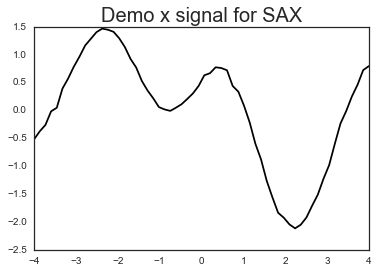

In [15]:
# A demo signal
np.random.seed(54321)
t_sax_demo = np.linspace(-4, 4, 60)
x_sax_demo = (
    (t_sax_demo - 3.5)*(t_sax_demo - 1)*(t_sax_demo + 0.5)*(t_sax_demo + 1)*
    (t_sax_demo + 3.5)*np.exp(-np.power(t_sax_demo, 2)/5) + 0.5*np.random.randn(len(t_sax_demo)))

mean_xsax = np.mean(x_sax_demo)
std_xsax = np.std(x_sax_demo)

x_sax_demo = (x_sax_demo - mean_xsax)/std_xsax

plt.plot(t_sax_demo, x_sax_demo, color='k')
plt.title('Demo x signal for SAX', fontsize=20)

In [16]:
# With 3 break points, 4 bins
bp1 = sp.stats.norm.ppf(1/4)
bp2 = sp.stats.norm.ppf(2/4)
bp3 = sp.stats.norm.ppf(3/4)
print('%.4f' % bp1)
print('%.4f' % bp2)
print('%.4f' % bp3)

-0.6745
0.0000
0.6745


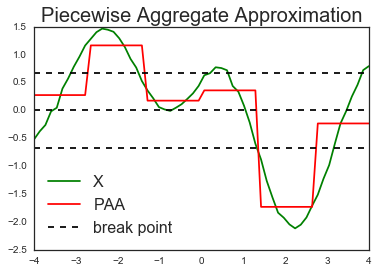

In [17]:
paa_sax_demo = np.zeros(len(x_sax_demo))
paa_sax_demo[:10] = np.mean(x_sax_demo[:10])
paa_sax_demo[10:20] = np.mean(x_sax_demo[10:20])
paa_sax_demo[20:30] = np.mean(x_sax_demo[20:30])
paa_sax_demo[30:40] = np.mean(x_sax_demo[30:40])
paa_sax_demo[40:50] = np.mean(x_sax_demo[40:50])
paa_sax_demo[50:] = np.mean(x_sax_demo[50:])

plt.plot(t_sax_demo, x_sax_demo, color='g', label='X')
plt.plot(t_sax_demo, paa_sax_demo, color='r', label='PAA')
plt.plot(t_sax_demo, bp1*np.ones(len(t_sax_demo)), color='k', linestyle="--", label='break point')
plt.plot(t_sax_demo, bp2*np.ones(len(t_sax_demo)), color='k', linestyle="--")
plt.plot(t_sax_demo, bp3*np.ones(len(t_sax_demo)), color='k', linestyle="--")
plt.legend(fontsize=16, loc=3)
plt.title('Piecewise Aggregate Approximation', fontsize=20)

This PAA, then, corresponds to the word __cdccab__, with bin __a__ for values $-\infty$ to $bp_1$, bin __b__ for values $bp_1$ to $bp_2$ and so on.

In [18]:
def generate_break_points(num_bp, stat_dist=sp.stats.norm()):
    bp_array = [stat_dist.ppf((ind + 1)/(num_bp + 1)) for ind in range(num_bp)]
    return np.array(bp_array)

In [19]:
bp3 = generate_break_points(3)
print(bp3)

[-0.67448975  0.          0.67448975]


In [20]:
def normalize_signal(x):
    mean = np.mean(x)
    stdev = np.std(x)
    normalized = (x-mean)/stdev
    return normalized

In [21]:
def generate_paa(x, word_size=6):
    avg_length = len(x)/word_size
    paa_array = np.zeros(word_size)
    for ind in range(word_size):
        start_ind = round(ind*avg_length)
        stop_ind = round((ind + 1)*avg_length)
        paa_array[ind] = np.mean(x[start_ind:stop_ind])
    return paa_array

In [22]:
@np.vectorize
def num_to_letter(num: int) -> str:
    # a = 97, b = 98, ...
    return chr(num + 97)

def paa_to_sax(paa, breakpoints, abc=False):
    # If abc is True, then we are making just a word of letters.
    if abc and len(breakpoints) > 25:
        raise ValueError('Not set to use alpha characters on a character set larger than 26 elements.')
        # I suppose one could use upper and lower case...
    if abc:
        sax = num_to_letter(np.searchsorted(breakpoints, paa))
        sax = ''.join(sax)
    else:
        sax = np.searchsorted(breakpoints, paa)
        sax = '-'.join(map(str, sax))
    return sax

In [23]:
paa_demo = generate_paa(x_sax_demo)
print(paa_demo)
sax_demo = paa_to_sax(paa_demo, bp3, abc=True)
print(sax_demo)

[ 0.2728925   1.16317678  0.17314957  0.35709465 -1.73059712 -0.23571637]
cdccab


## Heuristic Ordering

Now that we can approximate the signal by a short word, the plan for attack goes as follows:
- For each subsequence (starting from index $0$ to index $M-N-1$) figure out its related word.
- Make a table with each index, word, and space for word-count (we will get to that in a second).
- For each index, put the word and put it into a Trie (going by symbol). At the leaf of the trie, add the index to a list of all indicies with that word.
  - Using a Python dictionary (/hashmap) should probably work just the same, given that we don't do that much complicated stuff with tries.
- Once you've formed the trie, you can then go through the table of indicies, find the entry in the Trie, and find its length. That gives the word-count column.
- Find the index with the minimum word-count (which is usually just 1). That (/these) are the most likely candidate for the discord, and should be your first entry (/entries) in your outer loop. Beyond that, just randomly pick all the other indicies for an outer loop.
- For the inner loop, the most likely close candidates for a subsequence with a given word are all the same subsequences with the same word. So do those subsequences first, and then just randomly do all other subsequences.
- Also, if comparing $p = i$ and $q = j$ leads to a disqualification of $p = ii$, due to symmetry you can also reject $p = j$.

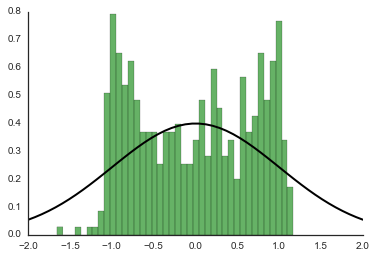

In [24]:
# N.B. The sine-wave signal I'm using does NOT follow a Gaussian distribution well at all, and instead peaks at
# -1 and 1. The performance of SAX as I was producing these notes was extremely poor, and so I'm picking different
# breakpoints (by eye) to get better performance. In practice, you might sample a short amount of data to get an
# idea of its distribution, and you can then apply to similar (longer) data.

plt.hist(x_array, normed=True, bins=40, color='g', alpha=0.6)
plt.plot(np.linspace(-2, 2), sp.stats.norm.pdf(np.linspace(-2, 2)), color='k', linewidth=2)
sns.despine()

In [25]:
from collections import defaultdict

def make_table_and_dict(x, N, breakpoints, word_size=6):
    # N.B. x should be prenormalized
    M = len(x)
    char_size = len(breakpoints) + 1
    abc = (char_size <= 26)
    fake_trie = defaultdict(list)
    sax_array = np.empty(M - N, dtype='object')
    for ind in range(M - N):
        subseq = x[ind:(ind+N)]
        paa = generate_paa(subseq, word_size=word_size)
        sax = paa_to_sax(paa, breakpoints, abc=abc)
        sax_array[ind] = sax
        fake_trie[sax].append(ind)
    
    sax_table = pd.DataFrame({'sax': sax_array})
    fake_trie_lens = dict()
    for key, val in fake_trie.items():
        fake_trie_lens[key] = len(val)
    sax_table['word_count'] = sax_table['sax'].apply(lambda word: fake_trie_lens[word])
    
    return sax_table, fake_trie

In [26]:
# N.B. If you want to use a trie, this would be the way to do the above code. A dict is
# a bit easier to deal with, however.

def make_table_and_trie(x, N, breakpoints, word_size=6):
    # N.B. x should be prenormalized
    M = len(x)
    char_size = len(breakpoints) + 1
    abc = (char_size <= 26)
    sax_array = np.empty(M - N, dtype='object')
    sax_array_for_trie = np.empty(M - N, dtype='object')
    sax_words = set()
    for ind in range(M - N):
        subseq = x[ind:(ind+N)]
        paa = generate_paa(subseq, word_size=word_size)
        sax = paa_to_sax(paa, breakpoints, abc=abc)
        sax_array[ind] = sax
        sax_array_for_trie[ind] = sax + '_%d' % ind
        sax_words.add(sax)
    sax_table = pd.DataFrame({'sax': sax_array})
    trie = marisa_trie.Trie(list(sax_array_for_trie))  # Trie doesn't accept ndarrays? Boo...
    trie_lens = dict()
    for word in sax_words:
        trie_lens[word] = len(trie.keys(word))
    sax_table['word_count'] = sax_table['sax'].apply(lambda word: trie_lens[word.split('_')[0]])
    
    return sax_table, trie

In [27]:
% timeit make_table_and_dict(x_array, 67, breakpoints=[-0.67, 0.67], word_size=7)

10 loops, best of 3: 45.6 ms per loop


In [28]:
% timeit make_table_and_trie(x_array, 67, breakpoints=[-0.67, 0.67], word_size=7)

10 loops, best of 3: 46.1 ms per loop


In [29]:
sax_table_ft, fake_trie = make_table_and_dict(x_array, 67, breakpoints=[-0.67, 0.67], word_size=7)

In [30]:
sax_table_rt, real_trie = make_table_and_trie(x_array, 67, breakpoints=[-0.67, 0.67], word_size=7)

In [31]:
sax_table_ft.head(15)

,sax,word_count
0,bccbaab,13
1,bccbaab,13
2,bcbbaab,16
3,bcbbaab,16
4,bcbbaab,16
5,ccbbaab,14
6,ccbbaab,14
7,ccbbabb,14
8,ccbbabb,14
9,ccbaabb,16


In [32]:
sax_table_ft[sax_table_ft['word_count'] == sax_table_ft['word_count'].min()]

,sax,word_count
150,cbbabbb,1
169,babbbbb,1
170,aabbbbb,1


In [33]:
sax_table_ft.iloc[200]

sax           bbbaaab
word_count          8
Name: 200, dtype: object

So we have 3 potential candidates of $\texttt{word_count} = 1$, a few of which are quite close to the true discord at 200 (though interestingly, the true discord is not among these candidates). Now let's try doing the heuristic ordering in practice.

In [34]:
# https://docs.python.org/3/library/itertools.html#itertools-recipes
from itertools import filterfalse

def unique_everseen(iterable, key=None):
    "List unique elements, preserving order. Remember all elements ever seen."
    # unique_everseen('AAAABBBCCDAABBB') --> A B C D
    # unique_everseen('ABBCcAD', str.lower) --> A B C D
    seen = set()
    seen_add = seen.add
    if key is None:
        for element in filterfalse(seen.__contains__, iterable):
            seen_add(element)
            yield element
    else:
        for element in iterable:
            k = key(element)
            if k not in seen:
                seen_add(k)
                yield element

In [35]:
def get_discord_hot_sax(X, N, sax_table, trie_or_dict):
    is_trie = isinstance(trie_or_dict, marisa_trie.Trie)

    M = len(X)
    assert N < M, "N must be smaller than the length of X"
    highest_distance = 0
    number_of_calls_to_RMS = 0
    p_candidate = np.nan
    
    # Figuring out p ordering
    goes_first = list(sax_table[sax_table['word_count'] == sax_table['word_count'].min()].index)
    np.random.shuffle(goes_first)
    goes_second_p = np.arange(M-N)
    np.random.shuffle(goes_second_p)
    p_list = goes_first + list(goes_second_p)
    p_ordering = unique_everseen(p_list)
    
    goes_second_q = np.arange(M-N)
    np.random.shuffle(goes_second_q)
    
    reject_list = np.zeros(M-N, dtype=bool)

    for p in p_ordering:
        if reject_list[p]:
            continue

        dist = np.inf
        x_p = X[p:(p+N)]
        lowest_distance_p = np.inf
        
        # Now for q ordering
        if is_trie:
            goes_first = [
                int(strg.split('_')[1])
                for strg
                in trie_or_dict.keys(sax_table['sax'][p])]
        else:
            goes_first = trie_or_dict[sax_table['sax'][p]]
        q_list = goes_first + list(goes_second_q)
        q_ordering = unique_everseen(q_list)
          
        for q in q_ordering:
            if np.abs(p-q) < N:
                # preventing self-matches
                continue
            x_q = X[q:(q+N)]
            dist = RMS_distance(x_p, x_q)
            number_of_calls_to_RMS += 1
            if dist < highest_distance:
                # We know this isn't a candidate.
                lowest_distance_p = dist
                reject_list[q] = True
                break
            lowest_distance_p = min(lowest_distance_p, dist)

        if lowest_distance_p > highest_distance:
            p_candidate = p
            highest_distance = lowest_distance_p

    return p_candidate, highest_distance, number_of_calls_to_RMS

In [36]:
np.random.seed(54321)

%timeit get_discord_hot_sax(x_array, 67, sax_table_ft, fake_trie)

p, rms_dist, num_calls = get_discord_hot_sax(x_array, 67, sax_table_ft, fake_trie)

print('Number of calls: %d' % num_calls)
print('Starting point of discord: %d' % p)

10 loops, best of 3: 93.3 ms per loop
Number of calls: 5210
Starting point of discord: 200


In [37]:
np.random.seed(54321)

%timeit get_discord_hot_sax(x_array, 67, sax_table_rt, real_trie)

p, rms_dist, num_calls = get_discord_hot_sax(x_array, 67, sax_table_rt, real_trie)

print('Number of calls: %d' % num_calls)
print('Starting point of discord: %d' % p)

10 loops, best of 3: 95.8 ms per loop
Number of calls: 5204
Starting point of discord: 200


Sadly this didn't work nearly as well as the pure-random sample, which took ~ 50 ms on my laptop (about the time spent just making the SAX table and dictionary). Trying a few different combinations...

In [38]:
np.random.seed(90210)
t0 = time.time()
sax_table, fake_trie = make_table_and_dict(x_array, 67, breakpoints=[-0.5, 0.5], word_size=7)
p, rms_dist, num_calls = get_discord_hot_sax(x_array, 67, sax_table, fake_trie)
t1 = time.time()
found_200 = 200 in sax_table[sax_table['word_count'] == sax_table['word_count'].min()].index
print('Run time: %.2f [ms], Num calls: %d. Discord has unique word: %s' % (1000*(t1-t0), num_calls, found_200))

Run time: 150.20 [ms], Num calls: 4532. Discord has unique word: False


In [39]:
np.random.seed(90210)
t0 = time.time()
sax_table, fake_trie = make_table_and_dict(x_array, 67, breakpoints=[-0.67, 0.67], word_size=10)
p, rms_dist, num_calls = get_discord_hot_sax(x_array, 67, sax_table, fake_trie)
t1 = time.time()
found_200 = 200 in sax_table[sax_table['word_count'] == sax_table['word_count'].min()].index
print('Run time: %.2f [ms], Num calls: %d. Discord has unique word: %s' % (1000*(t1-t0), num_calls, found_200))

Run time: 213.97 [ms], Num calls: 6604. Discord has unique word: False


In [40]:
np.random.seed(90210)
t0 = time.time()
sax_table, fake_trie = make_table_and_dict(x_array, 67, breakpoints=[-0.67, 0, 0.67], word_size=7)
p, rms_dist, num_calls = get_discord_hot_sax(x_array, 67, sax_table, fake_trie)
t1 = time.time()
found_200 = 200 in sax_table[sax_table['word_count'] == sax_table['word_count'].min()].index
print('Run time: %.2f [ms], Num calls: %d. Discord has unique word: %s' % (1000*(t1-t0), num_calls, found_200))

Run time: 157.52 [ms], Num calls: 4696. Discord has unique word: False


Still not great compared to randomness. But what if we have a much longer array?

In [41]:
M = 5000
t_array = np.linspace(0, 300, M)
dt = t_array[1]-t_array[0]

np.random.seed(135)
x_array = np.sin(np.pi*t_array/2) + 0.1*np.random.randn(M)
x_array[2000:2040] = x_array[2000:2040] - 0.7 + .3*np.random.randn(40)

In [42]:
np.random.seed(123)

t0 = time.time()
p_ordering = np.arange(M-67)
q_ordering = np.arange(M-67)
np.random.shuffle(p_ordering)
np.random.shuffle(q_ordering)
get_discord_hueristic_ordering(x_array, 67, p_ordering, q_ordering)

p, rms_dist, num_calls = get_discord_hueristic_ordering(x_array, 66, p_ordering, q_ordering)

t1 = time.time()

print('Number of calls: %d' % num_calls)
print('Starting point of discord: %d' % p)
print('Run time %.2f [s]' % ((t1 - t0)))

Number of calls: 179243
Starting point of discord: 1993
Run time 4.40 [s]


In [43]:
np.random.seed(90210)
t0 = time.time()
sax_table, fake_trie = make_table_and_dict(x_array, 67, breakpoints=[-0.5, 0.5], word_size=7)
p, rms_dist, num_calls = get_discord_hot_sax(x_array, 67, sax_table, fake_trie)
t1 = time.time()
print('Number of calls: %d' % num_calls)
print('Starting point of discord: %d' % p)
print('Run time %.2f [s]' % ((t1 - t0)))

Number of calls: 94681
Starting point of discord: 1992
Run time 3.05 [s]


In [44]:
# Just for comparison to see how long this takes for brute force.
# t0 = time.time()
# p, rms_dist, num_calls = get_discord_naive(x_array, 67)
# t1 = time.time()
# print('Run time %.2f [s]' % ((t1 - t0)))

# This took 4 min 45 sec on my laptop, and calls the distance function around 24M times

Now we're starting to do better. What if we go bigger?

In [ ]:
M = 20000
t_array = np.linspace(0, 1200, M)
dt = t_array[1]-t_array[0]

np.random.seed(135)
x_array = np.sin(np.pi*t_array/2) # + 0.1*np.random.randn(M)
x_array[2000:2040] = x_array[2000:2040] - 0.7 + .3*np.random.randn(40)

In [ ]:
np.random.seed(123)

t0 = time.time()
p_ordering = np.arange(M-67)
q_ordering = np.arange(M-67)
np.random.shuffle(p_ordering)
np.random.shuffle(q_ordering)
get_discord_hueristic_ordering(x_array, 67, p_ordering, q_ordering)

p, rms_dist, num_calls = get_discord_hueristic_ordering(x_array, 67, p_ordering, q_ordering)

t1 = time.time()

print('Number of calls: %d' % num_calls)
print('Starting point of discord: %d' % p)
print('Run time %.2f [s]' % ((t1 - t0)))

In [ ]:
np.random.seed(90210)
t0 = time.time()
sax_table, fake_trie = make_table_and_dict(x_array, 67, breakpoints=[-0.5, 0.5], word_size=7)
p, rms_dist, num_calls = get_discord_hot_sax(x_array, 67, sax_table, fake_trie)
t1 = time.time()
print('Number of calls: %d' % num_calls)
print('Starting point of discord: %d' % p)
print('Run time %.2f [s]' % ((t1 - t0)))

For $M = 20000$, the naive approach would run the distance function call around $400M$ times, and so we have a $4000 \times$ reduction in number of calls.

## Another example

I've downloaded data from [this link](http://www.cs.ucr.edu/~eamonn/discords/)--the data corresponding to figure 1 in the paper, showing an example of an ECG and a premature ventricular contraction.

In [ ]:
heart_data = np.loadtxt('qtdbsel102.txt')

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(heart_data[:5000, 0], heart_data[:5000, 1], color='k')
plt.xlabel('Time [s]', fontsize=20)
plt.ylabel('ECG', fontsize=20)
plt.tick_params(labelsize=16)
sns.despine()

Plotting this without time shows that the heart-beats take around 160 data points.

In [ ]:
heart_array = heart_data[:5000, 1]
plt.hist(heart_array, bins=40, color='g', alpha=0.6)
sns.despine()

The signal looks decently Gaussian (withn an extra little bit above) so I'll normalize and use Gaussian breakpoints.

In [ ]:
t0 = time.time()
bp2 = generate_break_points(2)
heart_array = normalize_signal(heart_array)
sax_table, fake_trie = make_table_and_dict(heart_array, 160, breakpoints=bp2, word_size=7)
p, rms_dist, num_calls = get_discord_hot_sax(heart_array, 160, sax_table, fake_trie)
t1 = time.time()

print("Run time: %.2f [s]" % (t1 - t0))
print("Discord at %d" % p)
print("Number of distance calls: %d" % num_calls)

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(heart_data[:5000, 0], heart_data[:5000, 1], color='k')
plt.plot(heart_data[p:(p+160), 0], heart_data[p:(p+160), 1], color='r', linewidth=2)
plt.xlabel('Time [s]', fontsize=20)
plt.ylabel('ECG', fontsize=20)
plt.tick_params(labelsize=16)
sns.despine()

And, as you can see, we've quickly found the odd-heart-beat out.

### Final thoughts

For getting more than 1 discord, you'll want to iterate the above process and exclude matches with existant discords.

I have no idea where the HOT acronym comes from; it's not actually in the paper. Heuristic Ordered Time-series? The world may never know.

With that said, Eamonn Keogh's research takes SAX into a number of different fields, as listed [on his website](http://www.cs.ucr.edu/~eamonn/selected_publications.htm). I recommend scanning the page just for finding some of his better named papers.

SAX has also been scaled to work with large data, in an extension called iSAX, which takes further approximations. Papers on EK's site.

In [ ]:
YouTubeVideo('Fo6aKnRnBxM')